# Introduction to Network Models
#### Author: [Erika Fille Legara](https://erikalegara.site)


[![License: MIT](https://img.shields.io/badge/License-MIT-yellow.svg)](https://github.com/eflegara/Network-Science-Lectures/blob/master/LICENSE.md)

For context, this notebook is accompanied by a lecture session under the Network Science course under [AIM's MSc in Data Science program](https://aim.edu/programs/degree-programs/master-science-data-science).

---

<table align="left" border=0>
<!-- <table class="tfo-notebook-buttons" align="left"> -->
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/eflegara/Network-Science-Lectures/blob/master/CN%20Models.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/eflegara/Network-Science-Lectures/blob/master/CN%20Models.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

---

Relevant references:
1. Erdős, P.; Rényi, A. (1959). "On Random Graphs. I". _Publicationes Mathematicae_. **6**: 290–297.
2. Watts, D. J.; Strogatz, S. H. (1998). "Collective dynamics of 'small-world' networks". _Nature_. **393** (6684): 440–442. 
3.  Barabási, A.-L.; Albert, R. ( 1999). "Emergence of scaling in random networks". _Science_. **286** (5439): 509–512.

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations
from scipy import stats
import scipy
from scipy.optimize import curve_fit
from scipy.stats import binom
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

## Erdős-Renyi Model (Random Network Model)

In a random network model, it is assumed that the links (or edges) in the network are formed, well, randomly. The randomness here refers to the existence of relationships between entities in a network. For example, if we are considering a friendship network and model the said network using one of the more famous random network models, the ER model, we are assuming that friendship connections are formed by some random chance $p$. We refer to this as the $G(n,p)$ model. We will discuss another variant below.   

Random networks have the following properties.

1. Degree distribution obeys a Binomial distribution and approximates a Poisson distribution for large $n$.
2. The network has **low clustering coefficient**.
3. The network has **short characteristic path length**.

Constructing a random graph is fairly straightforward. Again, one can start by listing all the possible edges that could exist in a graph with $n$ nodes; i.e., for a graph with $n$ nodes, there is a total of $L=n(n-1)/2$ possible links or edges. 

In a random network, each of these potential $L$ links has a probability $p$ of being present in the network and $q=1-p$ otherwise. It is easy to show that in a randomly generated network, the expected number of links $\bar{L}$ is $\frac{n(n-1)p}{2}$. 

This can also be verified algorithmically as shown in the next cell. 

As an example, let $N=100$ nodes and $p=0.001$. Mathematically, $\bar{L} = 4.95$. Let's check if the simulation results agree after running a total of 5000 experiments.

In [2]:
total_experiments = 5000
n = 100
p = 0.001
all_pairs = int(n*(n-1)/2.)

In [3]:
sums = []
for i in range(total_experiments):
    total_edges = 0
    for pair in range(all_pairs):
        if np.random.random() < p:
            total_edges = total_edges + 1
    sums.append(total_edges)
np.mean(sums)

4.976

Indeed, that's quite close to the expected number of links obtained analytically.

As mentioned, $G(n,p)$ is just one model for constructing a random network; another way is by initially defining the total number of nodes $n$ and total number of links $m$ then randomly generating graphs that have $n$ nodes and $m$ links, $G(n,m)$, then randomly choosing one of these generated graphs. 

The good news is that we need not explicitly write the code for these two models—although they're straightforward to write—since [networkx](https://networkx.org) actually has these graph generators.

```python
nx.erdos_renyi_graph(n,p)
nx.gnm_random_graph(n,m)
```

### Connectedness 
But what really is interesting for Erdős and Renyi about random network models ($G(n,p)$) is when a network becomes connected; that is, the critical probability of connection $p^*$ where a network transitions from a network that's scattered/disconnected to a connected one. A connected network is a network where a path exists between any two pair of nodes in the network. Let's visualize this by iterating through $p$ values generated using the command `np.logspace(-3,0,15)`; the arguments used are arbitrary.

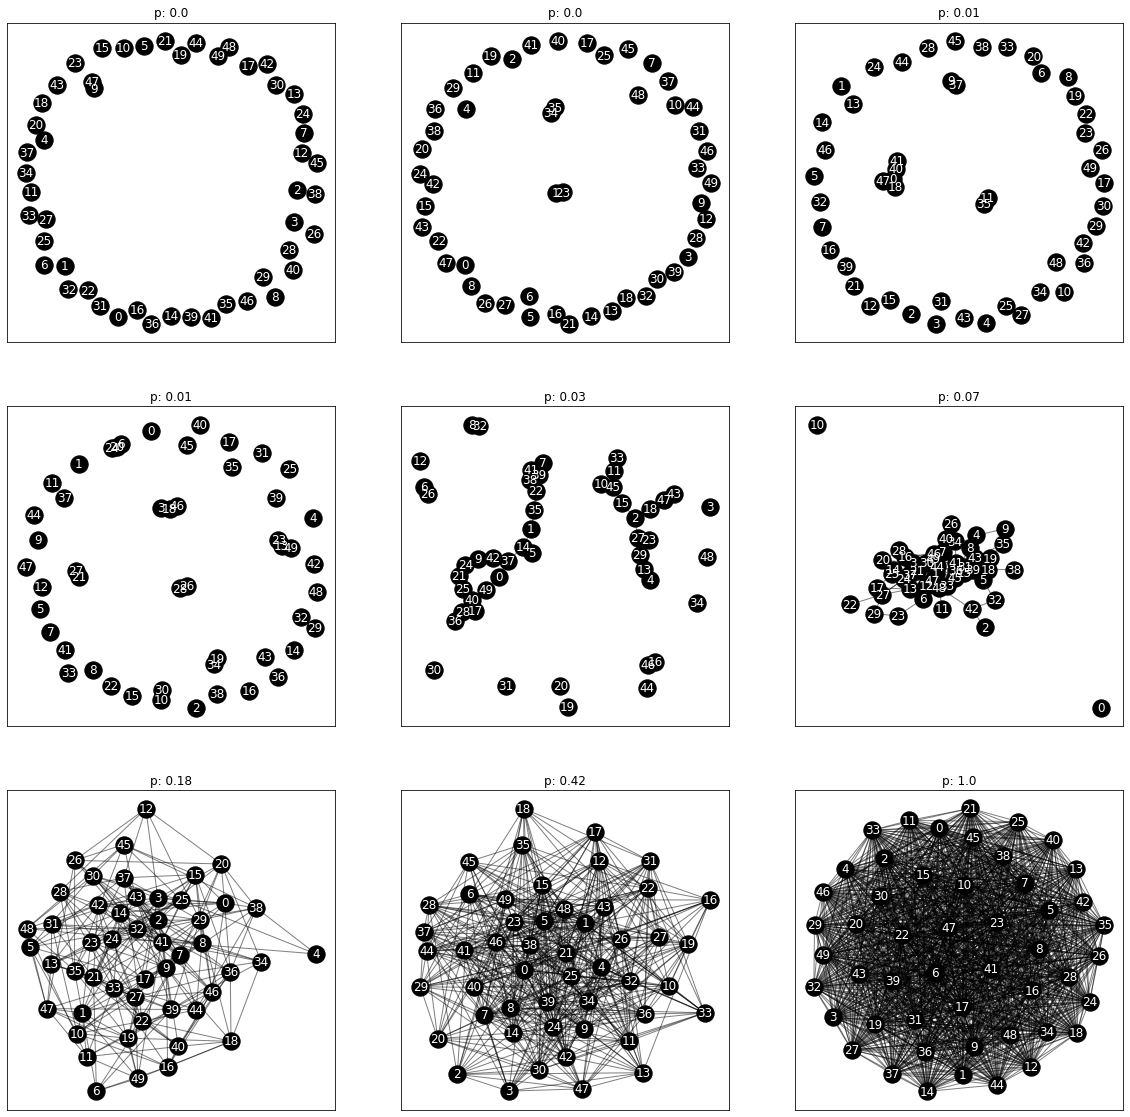

In [4]:
size = []
fig = plt.figure(figsize=(20,20));

i=0
for p in np.logspace(-3,0,9):
    ax = fig.add_subplot(3, 3, i+1);
    ER = nx.erdos_renyi_graph(n=50,p=p)
    pos = nx.fruchterman_reingold_layout(ER)
    nc = nx.draw_networkx_nodes(ER, pos=pos, node_size=300, cmap=plt.cm.RdYlBu,
                                node_color='black');
    nx.draw_networkx_edges(ER, pos=pos, alpha=0.500);
    nx.draw_networkx_labels(ER, pos=pos, font_color='white');
    plt.title("p: " + str(np.round(p,2)))
    i = i + 1
    

Analytically, Erdős and Renyi previously showed that the threshold $p^* \approx (\ln N)/N$.

We can explore this further by using `nx.is_connected(G)` to check whether the generated network is connected or not. 

As in above, let's build a small graph ($n=50$) and tune $p$ until a network becomes connected. This time, let's print the first $p$ value when the network becomes connected. In addition, let's hack a generalization with multiple experiments. A sample script is written below. In this example, as mentioned, we are using only a small graph ($n=500$), and we are also only performing a small experiment with only 500 iterations; bigger experiments take much longer time to complete.

In [5]:
pstar = []
n = 100
for i in range(1000):
    for p in np.logspace(-3,0,25):
        if nx.is_connected(nx.erdos_renyi_graph(n=n,p=p)):
            pstar.append(p)
            break

In [6]:
np.mean(pstar), np.std(pstar)

(0.05683916145867067, 0.011987432437884315)

According to ER, for $n=500$, the threshold $p^*$ is

In [7]:
np.log(n)/n

0.04605170185988092

There is, of course, an expected difference between the result of the in-silico experiments with that of the theoretical $p^*$, especially since we are only performing a few iterations.

### Degree Distribution
For a random network, we expect a Binomial distribution of degrees of connectivity; i.e.,

\begin{equation}
p(k) = {{n-1} \choose k} p^k (1-p)^{(n-1)-k}.
\end{equation}

${{n-1} \choose k}$ simply means that we select $k$ nodes from $(n-1)$ possible nodes where a node can be linked to.
For large $n$, the distribution approximates a Poissonian distribution.

\begin{equation}
p(k) = \exp ^{-<k>}\frac{<k>^k}{k!}
\end{equation}

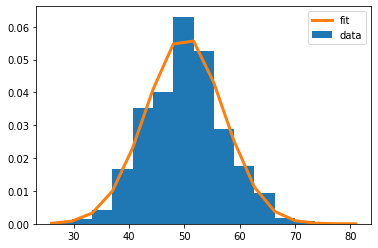

In [8]:
ax = plt.subplot(1,1,1)

ER = nx.erdos_renyi_graph(n=5000, p=0.01)
degrees = [k for node, k in nx.degree(ER)]

_, bins, _ = ax.hist(degrees, bins=15, density=True, label="data");
bin_middles = 0.5 * (bins[1:] + bins[:-1]);
mu, sigma = scipy.stats.norm.fit(degrees)
best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)

ax.plot(bins, best_fit_line, lw=3, label="fit");
plt.legend();

### Clustering Coefficient and Path Length

Aside from the degree distribution, the two other properties of networks usually computed are the **average clustering coefficient** $C$ and the **characteristic path length** $l$, which is the average shortest path length between all node pairs in the network. 

For the ER graph we have constructed, the $C$ and $l$ are

In [9]:
C = nx.average_clustering(ER)
l = nx.average_shortest_path_length(ER)
print("Clustering Coefficient:", C)
print("Characteristic Path Length:", l)

Clustering Coefficient: 0.00998628868203153
Characteristic Path Length: 2.5900752150430084


Note: For large $n$, computing the shortest path lengths for all pairs can take a while to complete.

The degree distribution, clustering coefficient, and characteristic path lengths are usually the first metrics investigated when studying real-world networks. They are part of the EDA. And the ER model ($G(n,m)$) or the $G(n,p)$ is a base model for complex networks; we use random network models to compare statistics vs. that of real-world networks. 

## Real-World Networks

So far, we have only looked at networks randomly generated algorithmically. How accurate are these models when studying/describing real-world networks? 

Let's have a look.

### C. elegans

The first network we have is the neural network of the *C. elegans* nematode \[1\]. 

> Note: If you are running this on Google Colab, the `nx.read_gml()` in the input cell below will result to an error; all other cells that read external files will result to errors since in Google Colab reading files is not straightforward. To fix the issue, download the datasets first from the Github repository and then upload them on your own Google Drive. Then execute the code:

```python
from google.colab import drive
drive.mount("/content/drive")
```

>Assuming you upload the data in a directory `MyData` on your drive, you may read the file as:

```python
data_dir = "/content/drive/MyDrive/MyData/"
marvel = pd.read_csv(data_dir + "hero-network.csv", header=None)
```

In [10]:
# load the graph from a gml file
G = nx.read_gml("datasets/celegansneural.gml", label="id")
G = nx.Graph(G)

In [11]:
# graph properties
print("No. of Nodes:", len(G.nodes()))
print("No. of Links:", len(G.edges()))

No. of Nodes: 297
No. of Links: 2148


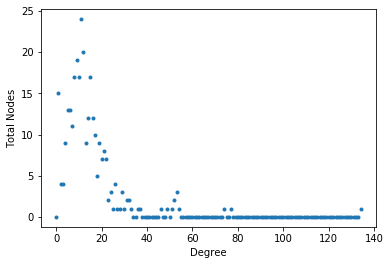

In [12]:
# degree distribution
plt.plot(nx.degree_histogram(G),'.');
plt.xlabel("Degree");
plt.ylabel("Total Nodes");

In [13]:
# clustering coefficient and the characteristic path length
cc = nx.average_clustering(G)
l = nx.average_shortest_path_length(G)
print(cc, l)

0.29236329783219017 2.455318955318955


As mentioned above, we can use a random network model for comparison. We can first compare the $C$ and $l$ values; and see if we can use a random network model to reproduce the numbers. To this we can construct a random network using the $G(n,m)$ model where $n$ and $m$ are the number of nodes and number of edges of the real-world network, respectively.

In [14]:
cc_random = nx.average_clustering(nx.gnm_random_graph(len(G.nodes()), len(G.edges()), seed=22))
l_random = nx.average_shortest_path_length(nx.gnm_random_graph(len(G.nodes()), len(G.edges()), seed=22))
print(cc_random, l_random)

0.048824612404298036 2.425175175175175


Comparing the $l$ values, we can see that they're within the same magnitude and are approximately the same. On the other hand, the clustering coefficient for the _C. elegans_ network is much higher than that generated by a random model. 

In [15]:
pd.DataFrame([[cc,l],[cc_random, l_random]], index = ["C. elegans NN", "Random network"], columns=["$C$", "$l$"])

,$C$,$l$
C. elegans NN,0.292363,2.455319
Random network,0.048825,2.425175


### Collaboration Network (Network Science)
Let's have a look at another real-world network.

In [16]:
G = nx.read_gml("datasets/netscience.gml", label="id")
G = nx.Graph(G)

In [17]:
nx.is_connected(G)

False

Since the graph is not connected, we cannot really compute for the characteristic path length since we will have distances of infinity for some node pairs (i.e., no path exists between them). What we'll do instead is have a look at the biggest subgraph (connected component; giant component) and analyze that.

But before that, let's have a look at the histogram first.

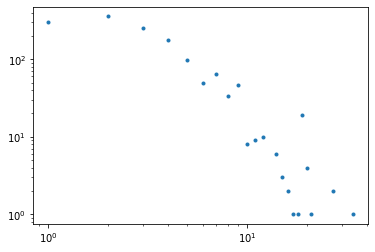

In [18]:
plt.loglog(nx.degree_histogram(G),'.');

The giant component of a network can be obtained by extracting all connected components of the graph and choosing the biggest one in terms of the number of nodes.

In [19]:
GC_nodes = max(nx.connected_components(G), key=len)
GC = G.subgraph(GC_nodes).copy()

In [20]:
cc = nx.average_clustering(GC)
l = nx.average_shortest_path_length(GC)
print(cc, l)

0.7412306142925664 6.041867347935949


In [21]:
# graph properties
print("No. of Nodes:", len(GC.nodes()))
print("No. of Links:", len(GC.edges()))


No. of Nodes: 379
No. of Links: 914


This is obviously a sparse graph where the total number of edges is very much less than the total number of potential links; i.e., $e << L$. Thus, we will only compute for the clustering coefficient since it will be challenging to generate random connected network with the provided $n$ and $m$ parameters.

In [22]:
cc_random = nx.average_clustering(nx.gnm_random_graph(len(GC.nodes()), len(GC.edges()), seed=22))
# l_random = nx.average_shortest_path_length(nx.gnm_random_graph(len(GC.nodes()), len(GC.edges()), seed=42))
print(cc_random)

0.007033775371506243


In [23]:
pd.DataFrame([[cc],[cc_random]], index = ["Collaboration network", "Random network"], columns=["$C$"])

,$C$
Collaboration network,0.741231
Random network,0.007034


As in the _C. elegans_ network, we can observe that the clustering coefficient for the collaboration network is much higher than the clustering coefficient of a random network of the same parameters, $n$ and $m$.

In fact, a similar trend was discovered by Watts and Strogatz when they studied the same _C. elegans_ network, a network of film actors, and a power grid network: the existence of high clustering coefficient and short path lengths.

## Small-World Model

Indeed, Watts and Strogatz discovered that some real-world networks exhibit certain properties, which are not present in random networks generated using the $G(n,p)$ and $G(n,m)$ models. In particular, the real-world networks they studied have high average clustering coefficients and short characteristic path lengths. 


Given their observation, they proposed another network model known as the small-world network model (aka Watts-Strogatz model). It's a generative model that reconstructs both the observed high clustering and short characteristic path lengths of many real-world networks. 

In the Watts-Strogatz model, graph generation begins with a regular network where each node is connected to $k$ other nodes in the network; i.e., all nodes have the same number of connections/neighbors. Then, with some probability $\rho$, each existing link in the network is rewired.
 
Let's build a Watts-Strogatz network with $n=5000$ nodes, $k=10$ average degree (for each node), and $\rho=0.15$ reconnection probability.

In [24]:
WS = nx.watts_strogatz_graph(n=5000, k=10, p=0.15)

In [25]:
cc = nx.average_clustering(WS)
l = nx.average_shortest_path_length(WS)
print(cc, l)

0.4139876057276074 5.124439047809562


Now, let's build a random network with the same $n$ total nodes and $e$ total edges.

In [26]:
cc_random = nx.average_clustering(nx.gnm_random_graph(len(WS.nodes()), len(WS.edges()), seed=22))
l_random = nx.average_shortest_path_length(nx.gnm_random_graph(len(WS.nodes()), len(WS.edges()), seed=22))
print(cc_random, l_random)

0.0018661421241297415 3.9459583116623325


In [27]:
pd.DataFrame([[cc,l],[cc_random, l_random]], index = ["WS model", "ER model"], columns=["$C$", "$l$"])

,$C$,$l$
WS model,0.413988,5.124439
ER model,0.001866,3.945958


Results show that the $l$ values for both ER and WS are comparable for the same $n$ and $e$; however, more clustering is observed in the WS model (given the high $C$) than the ER model.

Let's take again the *C. elegans* example and compare the statistics against those generated from both WS and ER models.

In [28]:
# load the graph from a gml file
G = nx.read_gml("datasets/celegansneural.gml", label="id")
G = nx.Graph(G)

In [29]:
def gen_network_comparisons(G, rho, network_name):
    avg_k = int(np.mean([deg for node, deg in G.degree()]))
    n = len(G.nodes())
    e = len(G.edges())
    
    ws_model = nx.watts_strogatz_graph(n=n, k=avg_k, p=rho)
    er_model = nx.gnm_random_graph(n=n, m=e)

    cc = nx.average_clustering(G)
    try:
        l = nx.average_shortest_path_length(G)
    except:
        l = "disconnected"
    cc_ws = nx.average_clustering(ws_model)
    try:
        l_ws = nx.average_shortest_path_length(ws_model)
    except:
        l_ws = "disconnected"
    cc_er = nx.average_clustering(er_model)
    try:
        l_er = nx.average_shortest_path_length(er_model)
    except:
        l_er = "disconnected"

    df = pd.DataFrame([[cc,l],[cc_ws, l_ws], [cc_er, l_er]], 
                      index = [network_name, "WS model", "ER model"],
                      columns=["$C$", "$l$"])
    return ws_model, er_model, df

In [30]:
print("C. Elegans Neural Network")
ws_model, er_model, df = gen_network_comparisons(G, 0.25, "NN")
df

C. Elegans Neural Network


,$C$,$l$
NN,0.292363,2.455319
WS model,0.320634,2.662321
ER model,0.048766,2.422195


We can see that the WS model was able to reconstruct the two characteristics of the *C. elegans* neural network. In contrast with the ER model, which was not able to reproduce the high clustering coefficient of the real-world network. In this respect, we can say that the WS model was able to reconstruct the real-world neural network; again, if we are to base the performance solely on $C$ and $l$. 

How about the degree distributions? How do they compare?

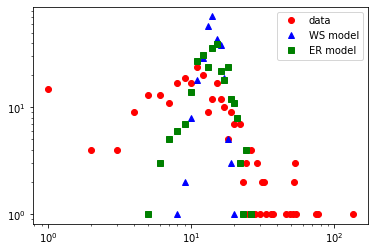

In [31]:
plt.loglog(nx.degree_histogram(G), "ro", label="data");
plt.loglog(nx.degree_histogram(ws_model), "b^", label="WS model");
plt.loglog(nx.degree_histogram(er_model), "gs", label="ER model");
plt.legend();

Thoughts on the patterns?

Now let's look at the collaboration network.

In [32]:
G = nx.read_gml("datasets/netscience.gml", label="id")
G = nx.Graph(G)
GC_nodes = max(nx.connected_components(G), key=len)
GC = G.subgraph(GC_nodes).copy()

print("Collaboration Network")
ws_model, er_model, df = gen_network_comparisons(GC, 0.035, "Collaboration Network")
df

Collaboration Network


,$C$,$l$
Collaboration Network,0.741231,6.04187
WS model,0.450836,10.8541
ER model,0.015488,disconnected


Any comment on the numbers? What happens when you change the reconnection probability of the WS model?

How about the degree distributions? How do they compare?

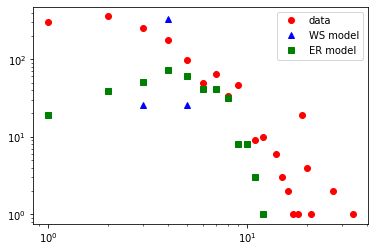

In [33]:
plt.loglog(nx.degree_histogram(G), "ro", label="data");
plt.loglog(nx.degree_histogram(ws_model), "b^", label="WS model");
plt.loglog(nx.degree_histogram(er_model), "gs", label="ER model");
plt.legend();

Thoughts on the numbers?

### Characteristic Path Length and Clustering Coefficient

Let's have a closer look at both the characteristic path length and the average clustering coefficient of networks generated by the WS model for different values of the rewiring probability $\rho$. In particular, let's look at the trend when we move from a regular network (WS$_{\rho=0}$), to a small-world network, to a random one (WS$_{\rho=1}$).

In [34]:
pvals = np.logspace(-3,0,10)
l_vals = []
c_vals = []
for p in pvals:
    G = nx.watts_strogatz_graph(n=1000, k=10, p=p, seed=222)
    l_vals.append(nx.average_shortest_path_length(G))
    c_vals.append(nx.average_clustering(G))

In [35]:
l_vals_normed = [l/l_vals[0] for l in l_vals]
c_vals_normed = [c/c_vals[0] for c in c_vals]

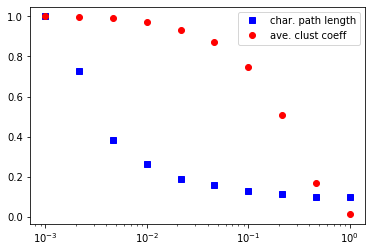

In [36]:
plt.semilogx(pvals,l_vals_normed,'bs', label = "char. path length");
plt.semilogx(pvals,c_vals_normed, 'ro', label = "ave. clust coeff");
plt.legend();

What can you say about the results?

## Barabási-Albert Model 

In a separate work (from Watts and Strogatz') on complex networks, Réka Albert and  Albert-László Barabási focused on the degree distribution of real-world networks. As you saw in the above examples and comparisons, although the WS model was _somehow_ able to capture the high clustering coefficient and short path length of the real-world networks, it wasn't really able to reconstruct the observed degree distributions. This gap is much more pronounced in large complex networks.

Let's take as an example the Enron email network.

### Enron Email

In [37]:
edges = np.loadtxt("datasets/Email-Enron.txt")
G_enron= nx.Graph()
G_enron.add_edges_from(edges)

In [38]:
nx.is_connected(G_enron)

False

In [39]:
GC_nodes = max(nx.connected_components(G_enron), key=len)
GC = G_enron.subgraph(GC_nodes).copy()
n = len(GC.nodes())
avg_k = int(np.mean([deg for node, deg in GC.degree()]))
e = len(GC.edges())

In [40]:
ws_model = nx.watts_strogatz_graph(n=n, k=avg_k, p=0.09)
er_model = nx.gnm_random_graph(n=n, m=e)

In [41]:
print("Enron Email Network")
pd.DataFrame([[nx.average_clustering(GC)],
              [nx.average_clustering(ws_model)],
              [nx.average_clustering(er_model)]], columns=["Clustering Coefficient"], 
             index = ["Email Network", 
                      "WS model", 
                      "ER model"])

Enron Email Network


,Clustering Coefficient
Email Network,0.509190
WS model,0.506894
ER model,0.000323


### Heavy-tail Degree Distribution

How about the degree distribution?

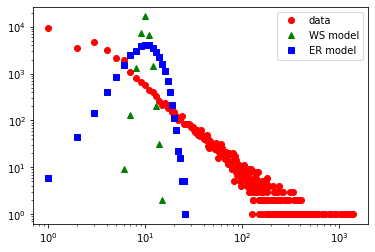

In [42]:
plt.loglog(nx.degree_histogram(GC),'ro', label="data");
plt.loglog(nx.degree_histogram(ws_model),'g^', label="WS model");
plt.loglog(nx.degree_histogram(er_model),'bs', label="ER model");
plt.legend();

We can see that the distributions generated by both the WS and ER models do not capture the true degree distribution of the real-world network, which is heavy-tailed.

To reflect this property of the degree distribution, Barabási and Albert proposed a network model that has two mechanisms: (1) growth and (2) preferential attachment. The idea is we start with a network of very few nodes and then  grow the network by adding nodes one at a time. The added nodes then attach themselves to $m$ existing nodes in the network with a preference for those nodes with higher degrees; i.e., those that have more connections are much more preferred by the new nodes. 

In [43]:
ba_model = nx.barabasi_albert_graph(n=n, m=avg_k)

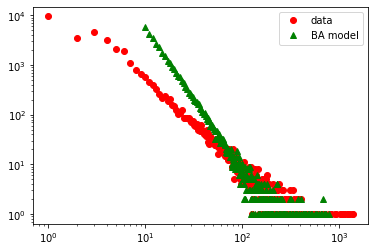

In [44]:
plt.loglog(nx.degree_histogram(GC),'ro', label="data");
plt.loglog(nx.degree_histogram(ba_model),'g^', label="BA model");
plt.legend();

Well, that looks like a better approximation of the degree distribution. What can you say about this degree distribution? 

### Other Statistics
How about the average clustering coefficient and the characteristic path length? 

*In this notebook, I won't be computing the characteristic path lengths for the networks since it takes a while to generate results.*

In [45]:
print("Enron Email Network")
pd.DataFrame([[nx.average_clustering(GC)],
              [nx.average_clustering(ws_model)],
              [nx.average_clustering(er_model)], 
              [nx.average_clustering(ba_model)]], columns=["Clustering Coefficient"], 
             index = ["Email Network", "WS model", "ER model", "BA model"])

Enron Email Network


,Clustering Coefficient
Email Network,0.509190
WS model,0.506894
ER model,0.000323
BA model,0.004015


# Final Thoughts?
Finally, how do you think will the model results change if we also used the [**configuration model**](https://en.wikipedia.org/wiki/Configuration_model)?